# Lab:  Source Localization for EEG

EEG or [Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) is a powerful tool for neuroscientists in understanding brain activity.  In EEG, a patient wears a headset with electrodes that measures voltages at a number of points on the scalp.  These voltages arise from ionic currents within the brain.  A common *inverse problem* is to estimate the which parts of the brain caused the measured response.  Source localization is useful in understanding which parts of the brain are involved in certain tasks.  A key challenge in this inverse problem is that the number of unknowns (possible locations in the brain) is much larger than the number of measurements.  In this lab, we will use LASSO regression on a real EEG dataset to overcome this problem and determine the brain region that is active under an auditory stimulus.

In addition to the concepts in the [prostate LASSO demo](./demo_prostate.ipynb) you will learn to:
* Represent responses of multi-channel time-series data, such as EEG, using linear models
* Perform LASSO and Ridge regression
* Select the regularization level via cross-validation
* Visually compare the sparsity between the solutions

We first download standard packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data. The following command will download a `pickle` file `eeg_dat.p` to your local machine.  If you do want to create the data yourself, the program to create the data is in this directory in the github repository.

In [ ]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

File eeg_dat.p is already downloaded


Now run the following command which will get the data from the `pickle` file.

In [ ]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)
print (X.shape)
print(Y.shape)

(305, 22494)
(305, 85)


To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Each current comes from one brain region (called a *voxel*) in either the `x`, `y` or `z` direction.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

Using `X.shape` and `Y.shape` compute and print `nt`, `nchan`, `ncur` and `nvoxels`.

In [ ]:
# TODO
nchan,ncur=X.shape
nchan,nt=Y.shape
nvoxels=ncur/3
print(nchan,nt,ncur,nvoxels)

305 85 22494 7498.0


## Ridge Regression

Our goal is to estimate the currents in the brain from the measurements `Y`.  One simple linear model is:

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Howeever, there is a problem:
*  There are `nt x ncur` unknowns in `W`
*  There are only `nt x nchan` measurements in `Y`.

In this problem, we have:

    number of measurements  << number of unknowns
    
We need to use regularization in these circumstances.  We first try Ridge regression.

First split the data into training and test.  Use the `train_test_split` function with `test_size=0.33`.

In [ ]:
# TODO
Xtr, Xts, ytr, yts = train_test_split(X,Y,test_size=0.33)

Use the `Ridge` regression object in `sklearn` to fit the model on the training data.  Use a regularization, `alpha=1`.

In [ ]:
# TODO
reg_rd = LinearRegression()
reg_rd = Ridge(alpha=1)
reg_rd.fit(Xtr, ytr)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Preict the values `Y` on both the training and test data.  Use the `r2_score` method to measure the `R^2` value on both the training and test.  You will see that `R^2` value is large for the training data, it is very low for the test data.  This suggest that even with regularization, the model is over-fitting the data.

In [ ]:
# TODO
yhat = reg_rd.predict(Xtr)
rsq_tr = r2_score(ytr, yhat)
print('Test R^2     = %f' % rsq_tr)
yhat = reg_rd.predict(Xts)
rsq_ts = r2_score(yts, yhat)
print('Test R^2     = %f' % rsq_ts)

Test R^2     = 0.600115
Test R^2     = 0.172340


Next, try to see if we can get a better `R^2` score using different values of `alpha`.  Use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}` (use `np.logspace()`).  You can use regular cross-validation.  You do not need to do `K`-fold.

In [ ]:
# TODO
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas_ridge = np.logspace(-2,2,20)
nalpha = len(alphas_ridge)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = Y[Itr,:]
    Xts = X[Its,:]
    yts = Y[Its,:]
    
    # Fit and transform the data
    for i, alphat in enumerate(alphas_ridge):

        # Fit on the training data
        reg = LinearRegression()
        reg = Ridge(alpha=alphat)
        reg.fit(Xtr, ytr)

        # Score on the test data
        yhat = reg.predict(Xts)
        rsq[i, ifold] = r2_score(yts, yhat)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_ridge_mean = np.mean(rsq, axis=1)
rsq_ridge_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


Plot the test `R^2` vs. `alpha`.  And print the maximum test `R^2`.  You should see that the maximum test `R^2` is still not very high.

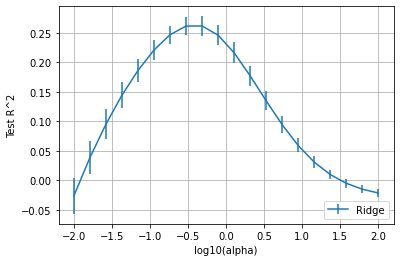

Optimal R^2 Ridge:  0.261845


In [ ]:
# TODO
plt.errorbar(np.log10(alphas_ridge), rsq_ridge_mean, yerr=rsq_ridge_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.legend(['Ridge'], loc='lower right')
plt.show()
print('Optimal R^2 Ridge:  %f' % np.max(rsq_ridge_mean))

Now, let's take a look at the solution. 

* Find the optimal regularization `alpha` from the cross-validation
* Re-fit the model at the optimal `alpha`
* Get the current matrix `W` from the coefficients in the linear model.  These are stored in `regr.coef_`.  You may need a transpose
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )` which is root mean squared current.

You will see that the vector `Wrms` is not sparse.  This means that the solution that is found with Ridge regression finds currents in all locations.

In [ ]:
# TODO
im = np.argmax(rsq_ridge_mean)
alpha_normal = alphas_ridge[im]
print('Alpha optimal (normal rule) = %12.4e' % alpha_normal)
print('Mean test R^2 (normal rule) = %7.3f' % rsq_ridge_mean[im])
regr=LinearRegression()
regr = Ridge(alpha=alpha_normal)
Xtr, Xts, ytr, yts = train_test_split(X,Y,test_size=0.33)
regr.fit(Xtr,ytr)
W=regr.coef_
W=np.transpose(W)
Wrms=np.zeros(ncur)
for i in range(0,ncur):
  Wrms[i]=np.sum(W[i,:]**2)
print(Wrms)

Alpha optimal (normal rule) =   4.8329e-01
Mean test R^2 (normal rule) =   0.262
[0.05822839 0.02152483 0.03555721 ... 0.00184391 0.001463   0.00703102]


## LASSO Regression

We can improve the estimate by imposing sparsity.  Biologically, we know that only a limited number of brain regions should be involved in the reponse to a particular stimuli.  As a result, we would expect that the current matrix `W[j,k]` to be zero for most values `j,k`.  We can impose this constraint using LASSO regularization.

Re-fit the training data using the `Lasso` model with `alpha=1e-3`.  Also set `max_iter=100` and `tol=0.01`.  The LASSO solver is much slower, so this make take a minute.

In [ ]:
# TODO
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
Xtr, Xts, ytr, yts = train_test_split(X,Y,test_size=0.33)
reg_ls=Lasso(alpha=0.001,max_iter=100,tol=0.01)
reg_ls.fit(Xtr,ytr)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Now, test the model on the test data and measure the `R^2` value.  You should get a much better fit than with the Ridge regression solution.  

In [ ]:
# TODO
yhatls = reg_ls.predict(Xts)
RSQ=r2_score(yts, yhatls)
print('Test R^2= %f' % RSQ)

Test R^2= 0.264358


We can now search for the optimal `alpha`.  Use cross-validation to find the `alpha` logarithically space between `alpha=10^{-3}` and `alpha=10^{-4}`.  Each fit takes some time, so use only 5 values of `alpha`. Also for each `alpha` store the current matrix.  This way, you will not have to re-fit the model.

In [ ]:
# TODO
from sklearn.model_selection import KFold
nfold = 2
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas = np.logspace(-4,-3,5)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = Y[Itr,:]
    Xts = X[Its,:]
    yts = Y[Its,:]

    for i, alphats in enumerate(alphas):

        # Fit on the training data
        reg=LinearRegression()
        reg = Lasso(alpha=alphats)
        reg.fit(Xtr, ytr)

        # Score on the test data
        yhat1 = reg.predict(Xts)
        rsq[i, ifold] = r2_score(yts, yhat1)
        print(alphats)
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_lasso_mean = np.mean(rsq, axis=1)
rsq_lasso_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

0.0001
0.00017782794100389227
0.00031622776601683794
0.0005623413251903491
0.001
Fold = 0
0.0001
0.00017782794100389227
0.00031622776601683794
0.0005623413251903491
0.001
Fold = 1


Plot the `r^2` value vs. `alpha`.  Print the optimal `r^2`.  You should see it is much higher than with the best Ridge Regression case.

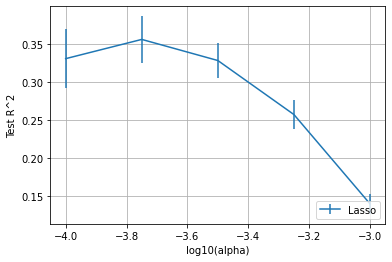

Optimal R^2 Ridge:  0.355873


In [ ]:
# TODO
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.legend(['Lasso'], loc='lower right')
plt.show()
print('Optimal R^2 Ridge:  %f' % np.max(rsq_lasso_mean))

Display the current matrix `W` for the optimal `alpha` as you did in the Ridge Regression case.  You will see that is much sparser.

In [ ]:
# TODO
im = np.argmax(rsq_lasso_mean)
alpha_normal = alphas[im]
print('Alpha optimal (normal rule) = %12.4e' % alpha_normal)
print('Mean test R^2 (normal rule) = %7.3f' % rsq_lasso_mean[im])
regr = Lasso(alpha=alpha_normal)
Xtr, Xts, ytr, yts = train_test_split(X,Y,test_size=0.33)
regr.fit(Xtr,ytr)
yhatls=regr.predict(Xts)
print(r2_score(yts,yhatls))
W=regr.coef_
W=np.transpose(W)
Wrms=np.zeros(ncur)
for i in range(0,ncur):
  Wrms[i]=np.sum(W[i,:]**2)
print(Wrms)

Alpha optimal (normal rule) =   1.7783e-04
Mean test R^2 (normal rule) =   0.356
0.341429935116764
[0.49517227 0.         0.         ... 0.         0.         0.        ]


## More fun

If you want to more on this lab:
* Install the [MNE python package](https://martinos.org/mne/stable/index.html).  This is an amazing package with many tools for processing EEG data.
* In particular, you can use the above results to visualize where in the brain the currents sources are.
* You can also improve the fitting with more regularization.  For example, we know that the currents will be non-zero in groups:  If the current is non-zero for one time, it is likely to non-zero for all time.  You can use the Group LASSO method.
* You can combine these results to make predictions about what the patient is seeing or hearing or thinking.